In [37]:
import cv2
from matplotlib import pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
from PIL import Image
from PIL import ImageFilter
from matplotlib import animation
from matplotlib import axes 
from PIL import ImageEnhance

from tkinter import filedialog
import tkinter as tk

import pickle

from os import sys

import matplotlib.pyplot as plt
import argparse

from statistics import mean
import os

%matplotlib inline

# for loading array 
from scipy.interpolate import interp1d
from scipy.io import loadmat
from scipy.optimize import curve_fit
from scipy import signal as sig
import pandas as pd
import numpy as np
from scipy.signal import filtfilt, butter


sys.path.append(r'C:\Users\Timothe\NasgoyaveOC\Professionnel\TheseUNIC\WorkScripts')
sys.path.append(r'C:\Users\Nicolas\Documents\GitHub\WorkScripts')

from LibrairieNico.HitsFctClass import smooth, Easyinterp, diff, calculateNewSize

## Functions declaration

In [7]:
def FindReferenceSystem2(video_path,height):
    
    HandleBEHAV = cv2.VideoCapture(video_path, 0)
    length = int(HandleBEHAV.get(cv2.CAP_PROP_FRAME_COUNT))
    
    _ , IMG1 = HandleBEHAV.read()

    linemask2= IMG1[height, : , 0]

    linemask2 = np.invert(linemask2)
    linemask2 = linemask2.flatten()

    smoothmask = smooth(linemask2)

    b, a = butter(8, 0.075)
    smoothfiltered = filtfilt(b, a, smoothmask)

    diffmask = np.diff(smoothfiltered,n=1)

    PeaksNO2 , values = sig.find_peaks(diffmask, height = 0.01)

    list1 = []

    if np.size(PeaksNO2) > 1: 

        var_Peaks = 1
        height = 0.01
        TakenHeight = []
        
        while np.size(PeaksNO2) > var_Peaks :
            height = height +0.01
            PeaksNO2_2 , values = sig.find_peaks(diffmask, height)
            
            if np.size(PeaksNO2_2) == 1:
                list1.append(PeaksNO2_2[0])
                TakenHeight.append(height)
                break
                
    Treshold = (TakenHeight[0])
    Peaks3 = ((list1 [0])  - 20)
    Peaks4 = ((list1 [0])  + 20)
    
    if Peaks3 < 0 :
        Peaks3 = 0
    if Peaks4 < 0 :
        Peaks4 = 0
        
    if Peaks3 > np.shape(IMG1)[1] :
        Peaks3 = np.shape(IMG1)[1]
    if Peaks4 > np.shape(IMG1)[1] :
        Peaks4 = np.shape(IMG1)[1]
    
    return [Peaks3,Peaks4,Treshold]
    
def HighestPeakFrom(peaks,values):
    if len(peaks) > 0 :
        values = values.get('peak_heights')
        peak = peaks[np.argmax(values)]
        value = values[np.argmax(values)]
        return peak, value 
    else:
        return np.nan, np.nan
    
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return (y)

def getHIT_LINE(Image,h_position,slice_pos,**kwargs):
    
    if 'reverse' in kwargs :
        DOreverse = kwargs.get('reverse')
    else : 
        DOreverse = False
        
    if 'clahe' in kwargs :
        DOclahe = kwargs.get('clahe')
        if DOclahe.__class__.__name__ == 'CLAHE':
            claheobj = DOclahe
            DOclahe = True
        elif DOclahe is True:
            claheobj = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(32,32))

    else:
        DOclahe = False
        
    if 'axis' in kwargs :
        axis = kwargs.get('axis')
    else:
        axis = 0
    
    if len(np.shape(Image)) > 2 :
        Image = Image[:,:,0]
        
    if DOreverse :
        Image = cv2.bitwise_not(Image)

    if DOclahe :
        Image = claheobj.apply(Image)

    if axis == 0:
        Slice = Image[int(slice_pos[0]):int(slice_pos[1]),h_position]
    elif axis == 1:
        Slice = Image[h_position,int(slice_pos[0]):int(slice_pos[1])]
    else:
        raise ValueError(f"Axis :{axis} is out of shape for 2D image of dimension {np.shape(Image)} with {len(np.shape(Image))} axes(starting at 0)")
    
    return np.reshape(Slice, (1, np.size(Slice)))


def getSigmoidEdgePeak(Y_data,**kwargs):
    
    Y_data = Y_data.flatten()
    
    if 'lowpass_raw' in kwargs :
        lowpass = kwargs.get('lowpass_raw')
        Y_data = filtfilt(lowpass[0], lowpass[1], Y_data)            
    
    X_data = np.arange(0,np.shape(Y_data)[0],1)
    
    p0 = [max(Y_data), np.median(X_data), 1, min(Y_data)]
    
    popt, pcov = curve_fit(sigmoid, X_data, Y_data, p0 , method='dogbox')
    
    if 'interp' in kwargs :
        interp_multplicator = kwargs.get('interp')
    else :
        interp_multplicator = False
        
    if interp_multplicator :
        X_data = np.arange(0,np.shape(Y_data)[0],1/interp_multplicator)
    
    FittedSlice = sigmoid(X_data, *popt)
    
    if 'lowpass_diff' in kwargs :
        lowpass = kwargs.get('lowpass_diff')
        DerivedSlice = filtfilt(lowpass[0], lowpass[1], np.diff(FittedSlice))
    else :
        DerivedSlice = np.diff(FittedSlice)
        
    return np.reshape(DerivedSlice, (1, np.size(DerivedSlice))) , np.reshape(FittedSlice, (1, np.size(FittedSlice)))

## VIDEO DEPENDANT PARAMETERS

In [8]:
#video_path = r"C:\Users\Nicolas\Desktop\Test_Hit\Mouse25_2020-02-07T11.15.51.avi"

#video_path =  r"D:\BehavioralVideos\Whisker_Video\Whisker_Topview\Expect_1\Mouse25\200207_1\Mouse25_2020-02-07T11.15.51.avi" #(nohitvideo)
video_path = r"C:\Users\Nicolas\Desktop\Videos\Test_Hit\Mouse24_2020-02-10T14.45.21.avi"  #(hitvideo)

interpMultiplicator = 10 #Determine the precision with wich we want to subdivide pixels to avoid "square" signals in edges coordinates

Obj_heights = [140,601] # these are the coordinates at wich we will seach objects with FindReferenceSystem2 function

HandleBEHAV = cv2.VideoCapture(video_path, 0)
Videolength = int(HandleBEHAV.get(cv2.CAP_PROP_FRAME_COUNT))

claheobj = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(32,32)) # initialize the clahe object once, to save time

b, a = butter(3, 0.100) # butterworth lowpass filters initialization
 
b2, a2 = butter(3, 0.300) # butterworth lowpass filters initialization

# OBJECT n°1
----------------
## Object dependant parameters and variables initialization ( for object 1 here with Object = 0 selected as reference system)

In [9]:
Object = 0
Reference_peaks2 = FindReferenceSystem2(video_path,Obj_heights[Object])

SliceLength = Reference_peaks2[1]-Reference_peaks2[0]
print(f"Length of the reference slice found : {SliceLength} for the object {Object+1}.\nReference slice indices and size of peak {Reference_peaks2} (in pixel value per pixel, squared)")

Length of the reference slice found : 40 for the object 1.
Reference slice indices and size of peak [324, 364, 0.8700000000000006] (in pixel value per pixel, squared)


## Sigmoid edge fitting over the whole video ( loop for one object only )

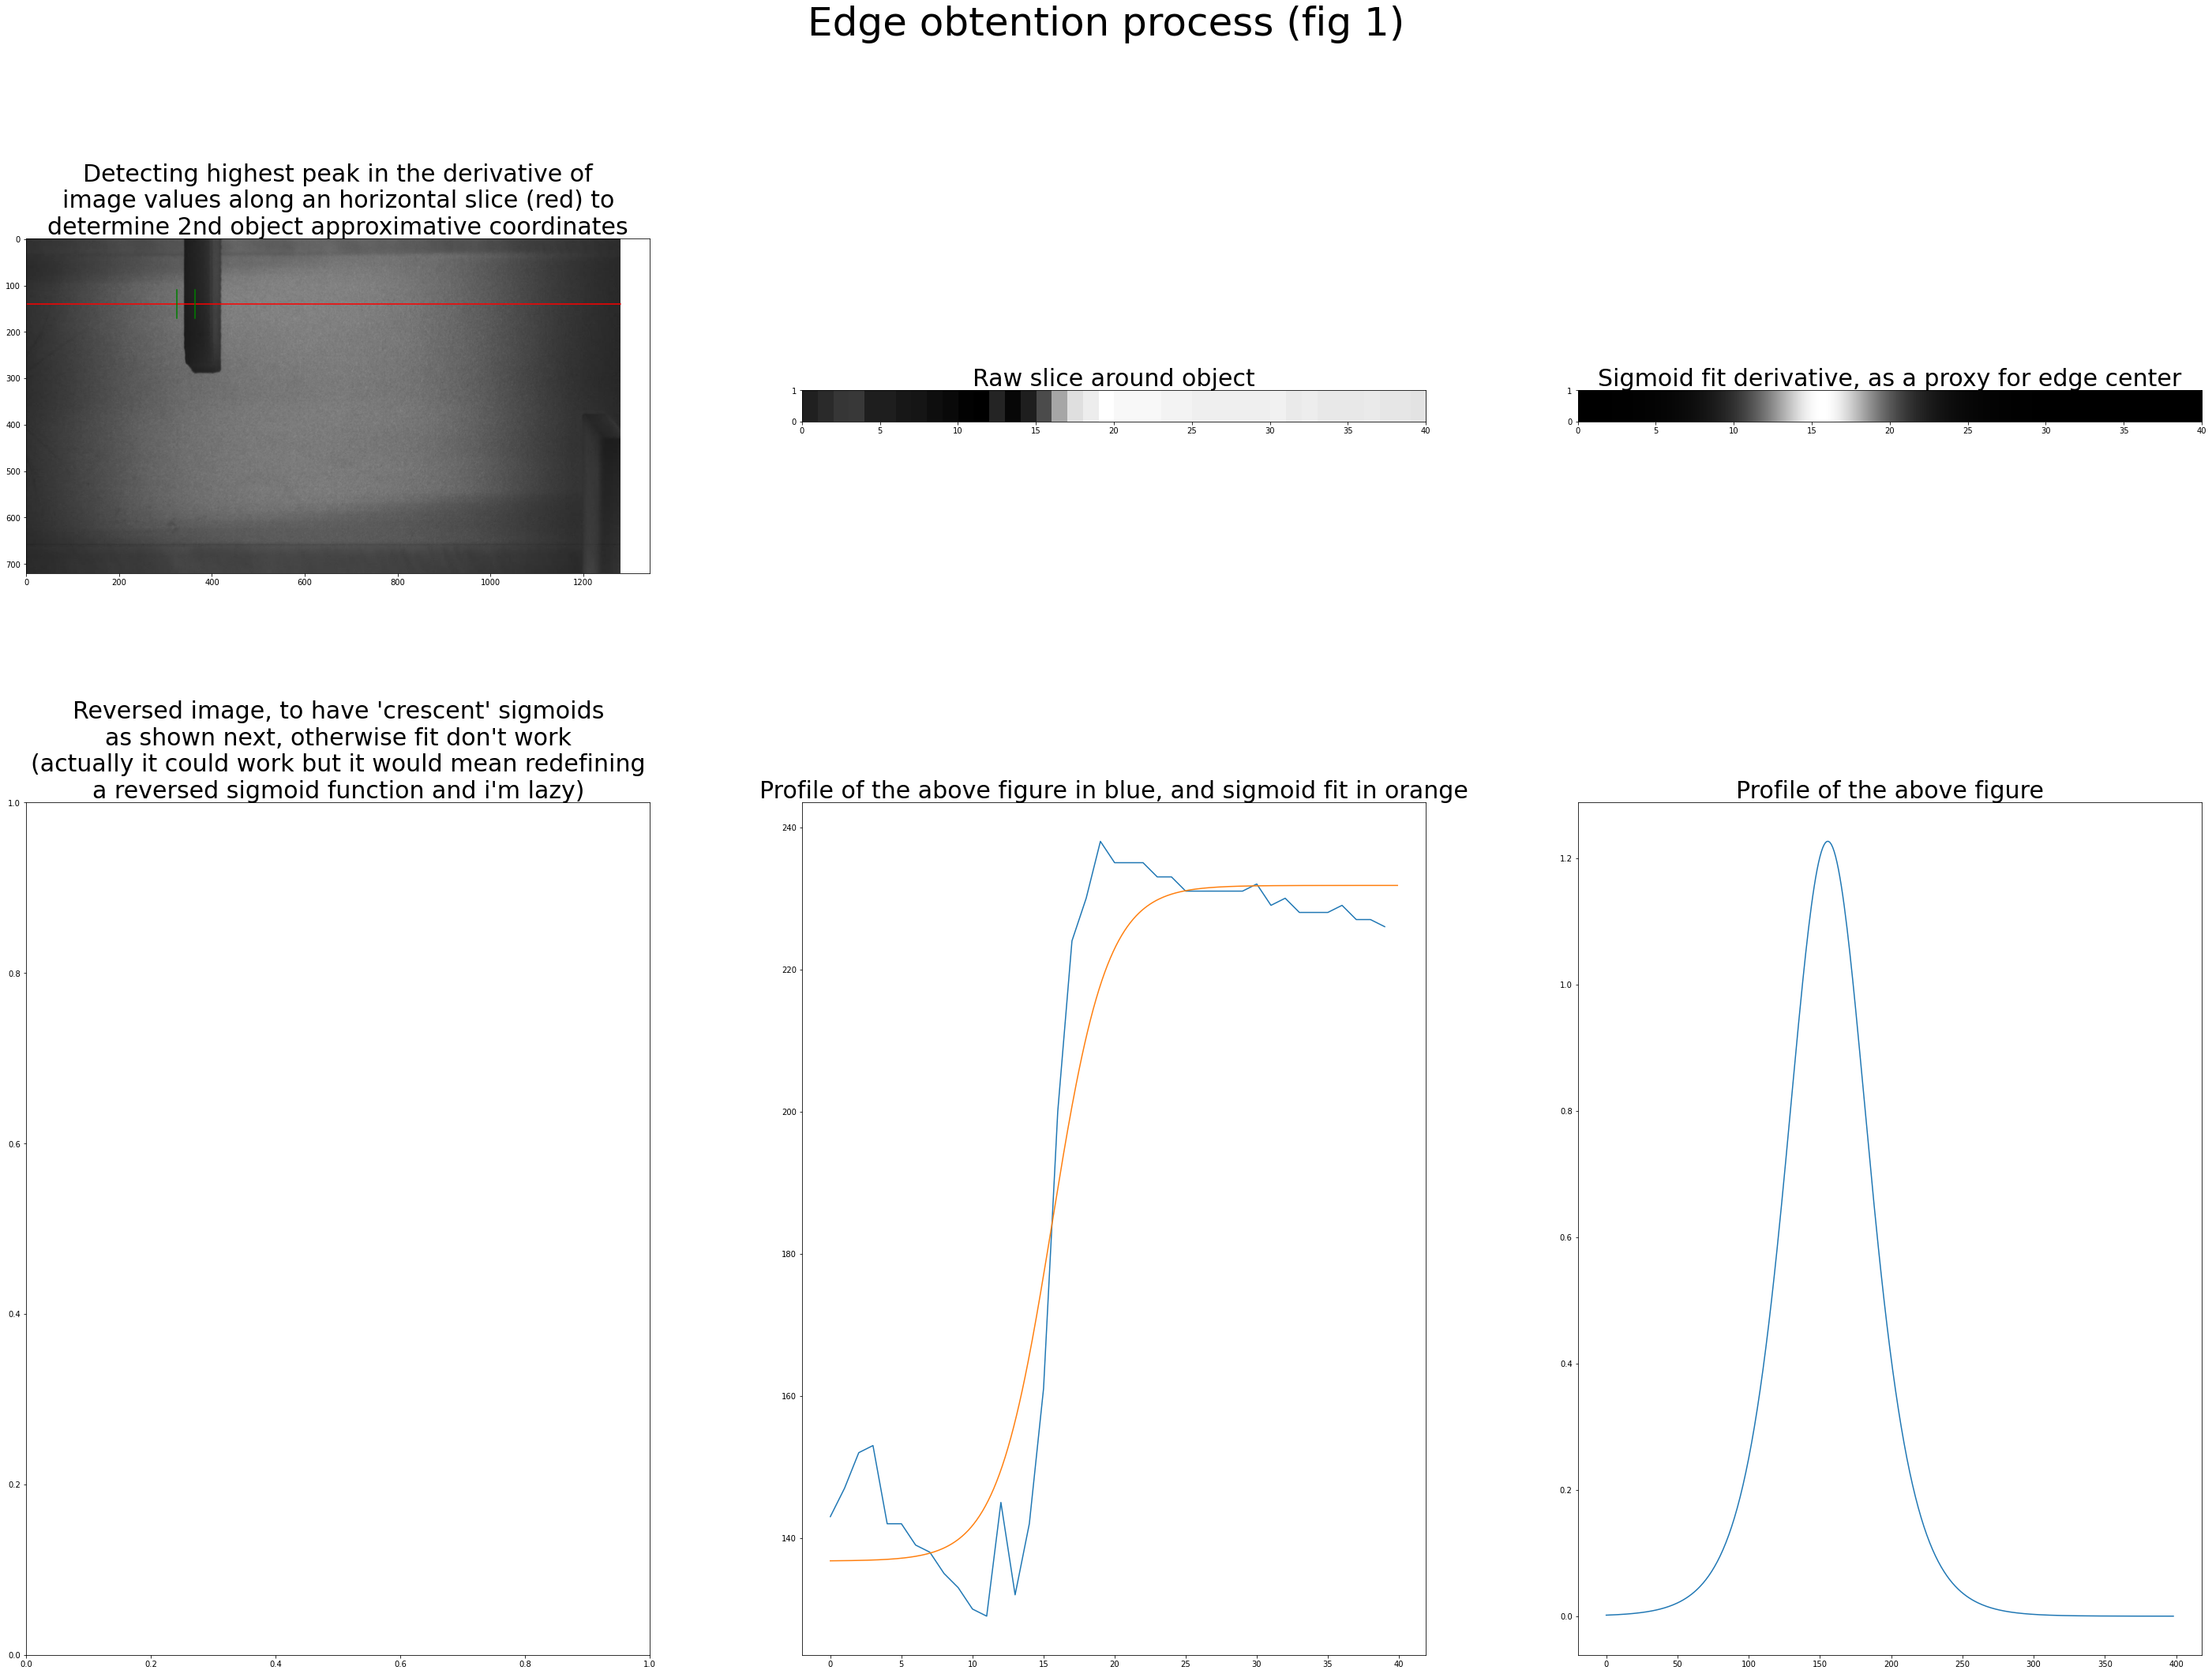

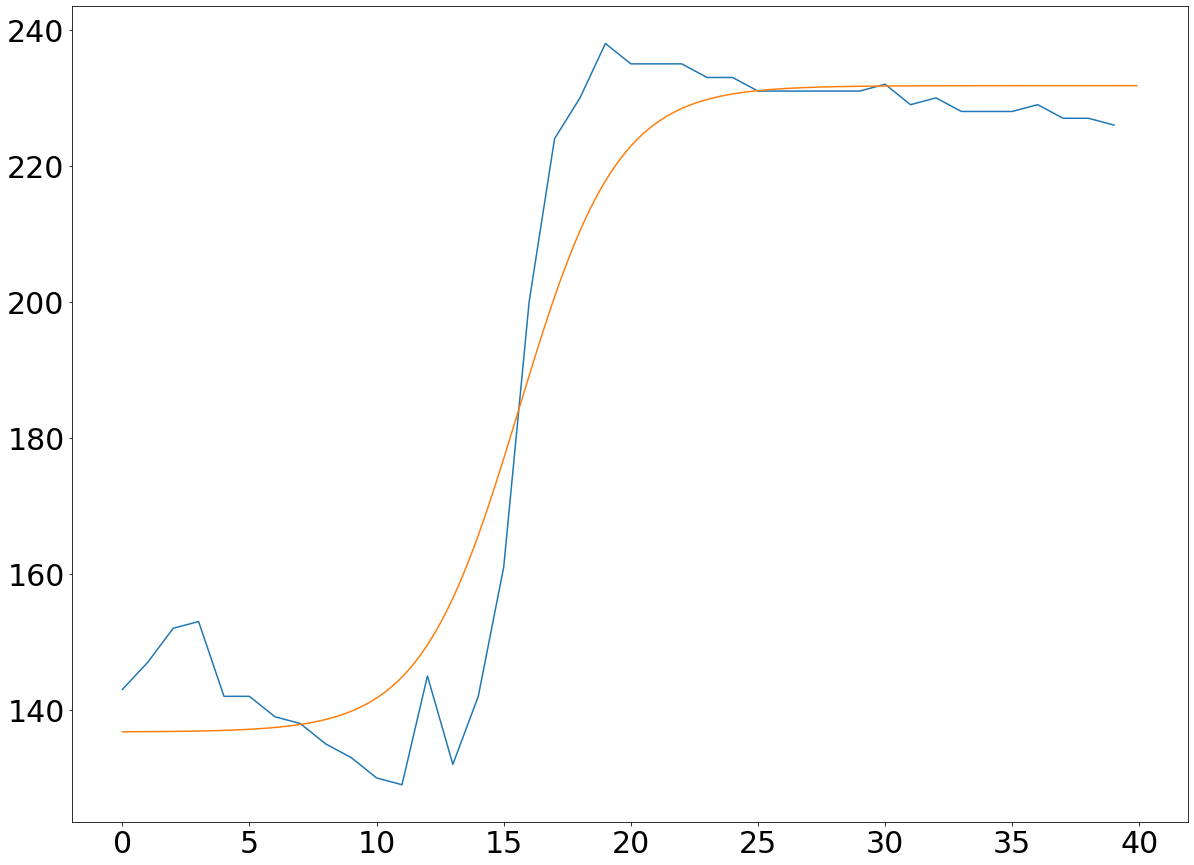

C:\ProgramData\Anaconda3\envs\ArduinoComs\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [51]:
TimeImage = np.empty((0,SliceLength)) # initializing the "images with the slices over time, as empty numpy array to start the loop below"
Diff_TimeImage = np.empty((0,(SliceLength*interpMultiplicator)-1)) # initializing the "images with the slices over time, as empty numpy array to start the loop below"
 
HandleBEHAV.set(cv2.CAP_PROP_POS_FRAMES,0)

for framne_nb in range(Videolength) :

    _ , Image = HandleBEHAV.read() # read a frame

    Slice_temp = getHIT_LINE(Image,Obj_heights[Object],Reference_peaks2[0:2],reverse = True, clahe = True, axis = 1) 
    # getHIT_LINE function process the frame to reverse pixels colors, do clahe eventually, and extract the slice needed to perform the analysis 

    TimeImage = np.append(TimeImage, Slice_temp ,axis = 0 )
    # appending the slice to make the grey image shown in the first plot in figure 2
    
    DiffSlice_temp, Fit = getSigmoidEdgePeak(Slice_temp, lowpass_raw = [b, a], lowpass_diff = [b2, a2], interp = interpMultiplicator )
    # getSigmoidEdgePeak function process the slice to filter, fit a sigmoid, derivate this sigmoid, filter again to be sure the signal is clean, with one nice "gaussian like" peak, and return the result
    
    Diff_TimeImage = np.append(Diff_TimeImage, DiffSlice_temp ,axis = 0)
    # appending the slice to make the "blue green" image shown in the second plot in figure 2
    
    if framne_nb == 1:
        fig = plt.figure(figsize = (40,30))

        PeakColor = 'red'

        plt.subplot(231)######################
        plt.imshow(Image, 'gray')
        plt.plot([0,np.shape(Image)[1]],[Obj_heights[Object],Obj_heights[Object]],PeakColor)
        plt.plot([Reference_peaks2[0],Reference_peaks2[0]],[Obj_heights[Object]+30,Obj_heights[Object]-30],'green')
        plt.plot([Reference_peaks2[1],Reference_peaks2[1]],[Obj_heights[Object]+30,Obj_heights[Object]-30],'green')
        plt.title("Detecting highest peak in the derivative of\nimage values along an horizontal slice (red) to\ndetermine 2nd object approximative coordinates",fontsize = 30)
        
        plt.subplot(232)######################
        plt.imshow(Slice_temp, 'gray', extent=[0,SliceLength,0,1], aspect=2)
        plt.title("Raw slice around object",fontsize = 30)
        
        ax = plt.subplot(233)######################
        plt.imshow(DiffSlice_temp, 'gray', extent=[0,SliceLength,0,1], aspect=2)
        plt.title("Sigmoid fit derivative, as a proxy for edge center",fontsize = 30)
        
        ax = plt.subplot(234)######################
        #Image = cv2.bitwise_not(Image)
        #plt.imshow(Image, 'gray')
        plt.title("Reversed image, to have 'crescent' sigmoids\nas shown next, otherwise fit don't work\n(actually it could work but it would mean redefining\na reversed sigmoid function and i'm lazy)",fontsize = 30)
        
        ax = plt.subplot(235)######################
        plt.plot(Slice_temp.flatten())
        plt.plot(np.arange(0,np.shape(Slice_temp)[1],1/interpMultiplicator),Fit.flatten())
        plt.title("Profile of the above figure in blue, and sigmoid fit in orange",fontsize = 30)
        
        ax = plt.subplot(236)######################
        plt.plot(DiffSlice_temp.flatten())
        plt.title("Profile of the above figure",fontsize = 30)
        
        plt.tight_layout()
        fig.suptitle('Edge obtention process (fig 1)', fontsize=50)

        plt.savefig("fig1.png")
        plt.show()
        
        
        plt.figure(figsize = (20,15))
        plt.plot()######################
        plt.plot(Slice_temp.flatten())
        plt.plot(np.arange(0,np.shape(Slice_temp)[1],1/interpMultiplicator),Fit.flatten())
        plt.plot(DiffSlice_temp.flatten())
        plt.xticks(fontsize=30)
        plt.yticks(fontsize=30)
        plt.show()
        

## Extracting coordinates of edge sigmoids

In [52]:
edges = []
for I in range(np.shape(Diff_TimeImage)[0]):

    DPeaks , values = sig.find_peaks(Diff_TimeImage[I,:], height = 1/interpMultiplicator)
    DPeaks,values = HighestPeakFrom(DPeaks,values)
    edges.append(DPeaks)

edges = np.asarray(edges).astype(float)
edges = edges/interpMultiplicator
mean = np.nanmean(edges)
print(f"Mean of the values for the edge detected over time :{mean}")

Mean of the values for the edge detected over time :15.627199999999998


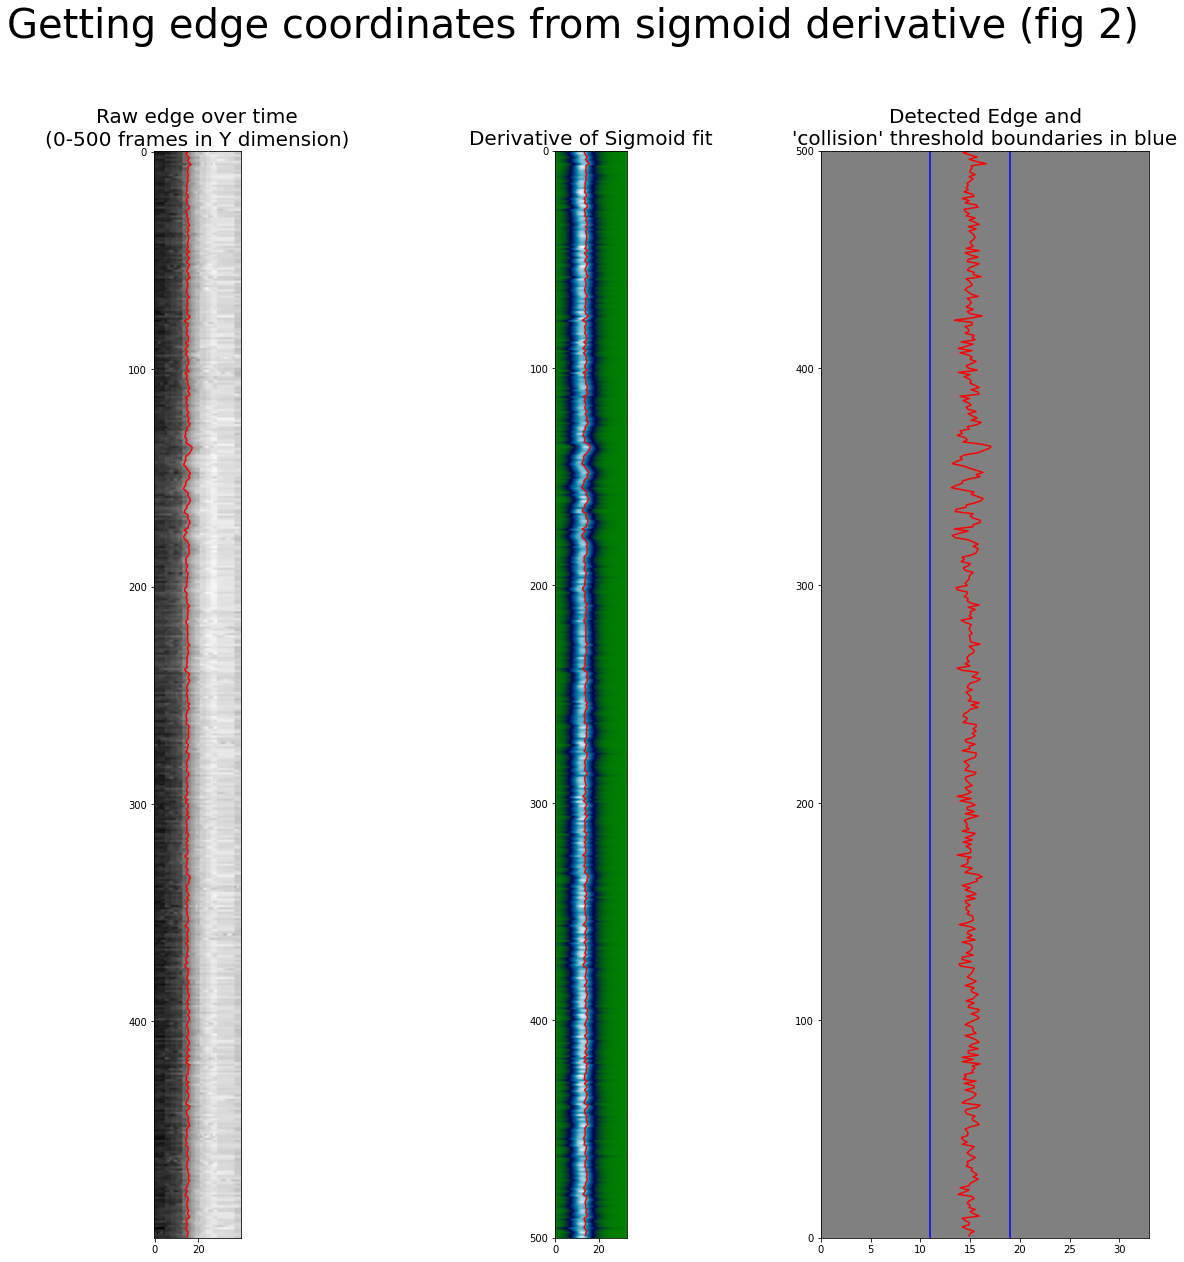

In [63]:
fig = plt.figure(figsize = (20,20))

PeakColor = 'red'

plt.subplot(131)######################
plt.imshow(TimeImage, 'gray')
plt.plot(edges,np.arange(0,len(edges),1),PeakColor)
plt.title("Raw edge over time\n(0-500 frames in Y dimension)",fontsize = 20)

plt.subplot(132)######################
plt.imshow(Diff_TimeImage, 'ocean', extent=[0,33,500,0], aspect=1)
plt.plot(edges-1,np.arange(0,len(edges),1),PeakColor)
plt.title("Derivative of Sigmoid fit",fontsize = 20)

ax = plt.subplot(133)######################
plt.plot(edges,np.arange(len(edges),0,-1),PeakColor)
plt.ylim(0,500)
plt.xlim(0,33)
plt.plot([mean-4,mean-4],[0,500],'blue')
plt.plot([mean+4,mean+4],[0,500],'blue')
ax.set_facecolor('gray')
plt.title("Detected Edge and\n'collision' threshold boundaries in blue",fontsize = 20)

fig.suptitle('Getting edge coordinates from sigmoid derivative (fig 2)', fontsize=40)

plt.savefig("fig2.png")
plt.show()

## Saving edges of object 1 in a copied array (numpy arrays use inRAM pointers so a copy is needed to not erase the data when using the same variable name below for object 2)

In [54]:
edges_Obj1 = np.copy(edges)

# OBJECT n°2
------------------
## Object dependant parameters and variables initialization ( for object 2 here with Object = 1 selected as reference system)

In [55]:
Object = 1
Reference_peaks2 = FindReferenceSystem2(video_path,Obj_heights[Object])

SliceLength = Reference_peaks2[1]-Reference_peaks2[0]
print(f"Length of the reference slice found :{SliceLength} for the object {Object+1}.\nReference slice indices and size of peak {Reference_peaks2} (in pixel value per pixel, squared)")

Length of the reference slice found :40 for the object 2.
Reference slice indices and size of peak [1219, 1259, 0.4000000000000002] (in pixel value per pixel, squared)


C:\ProgramData\Anaconda3\envs\ArduinoComs\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


## Sigmoid edge fitting over the whole video ( loop for one object only )

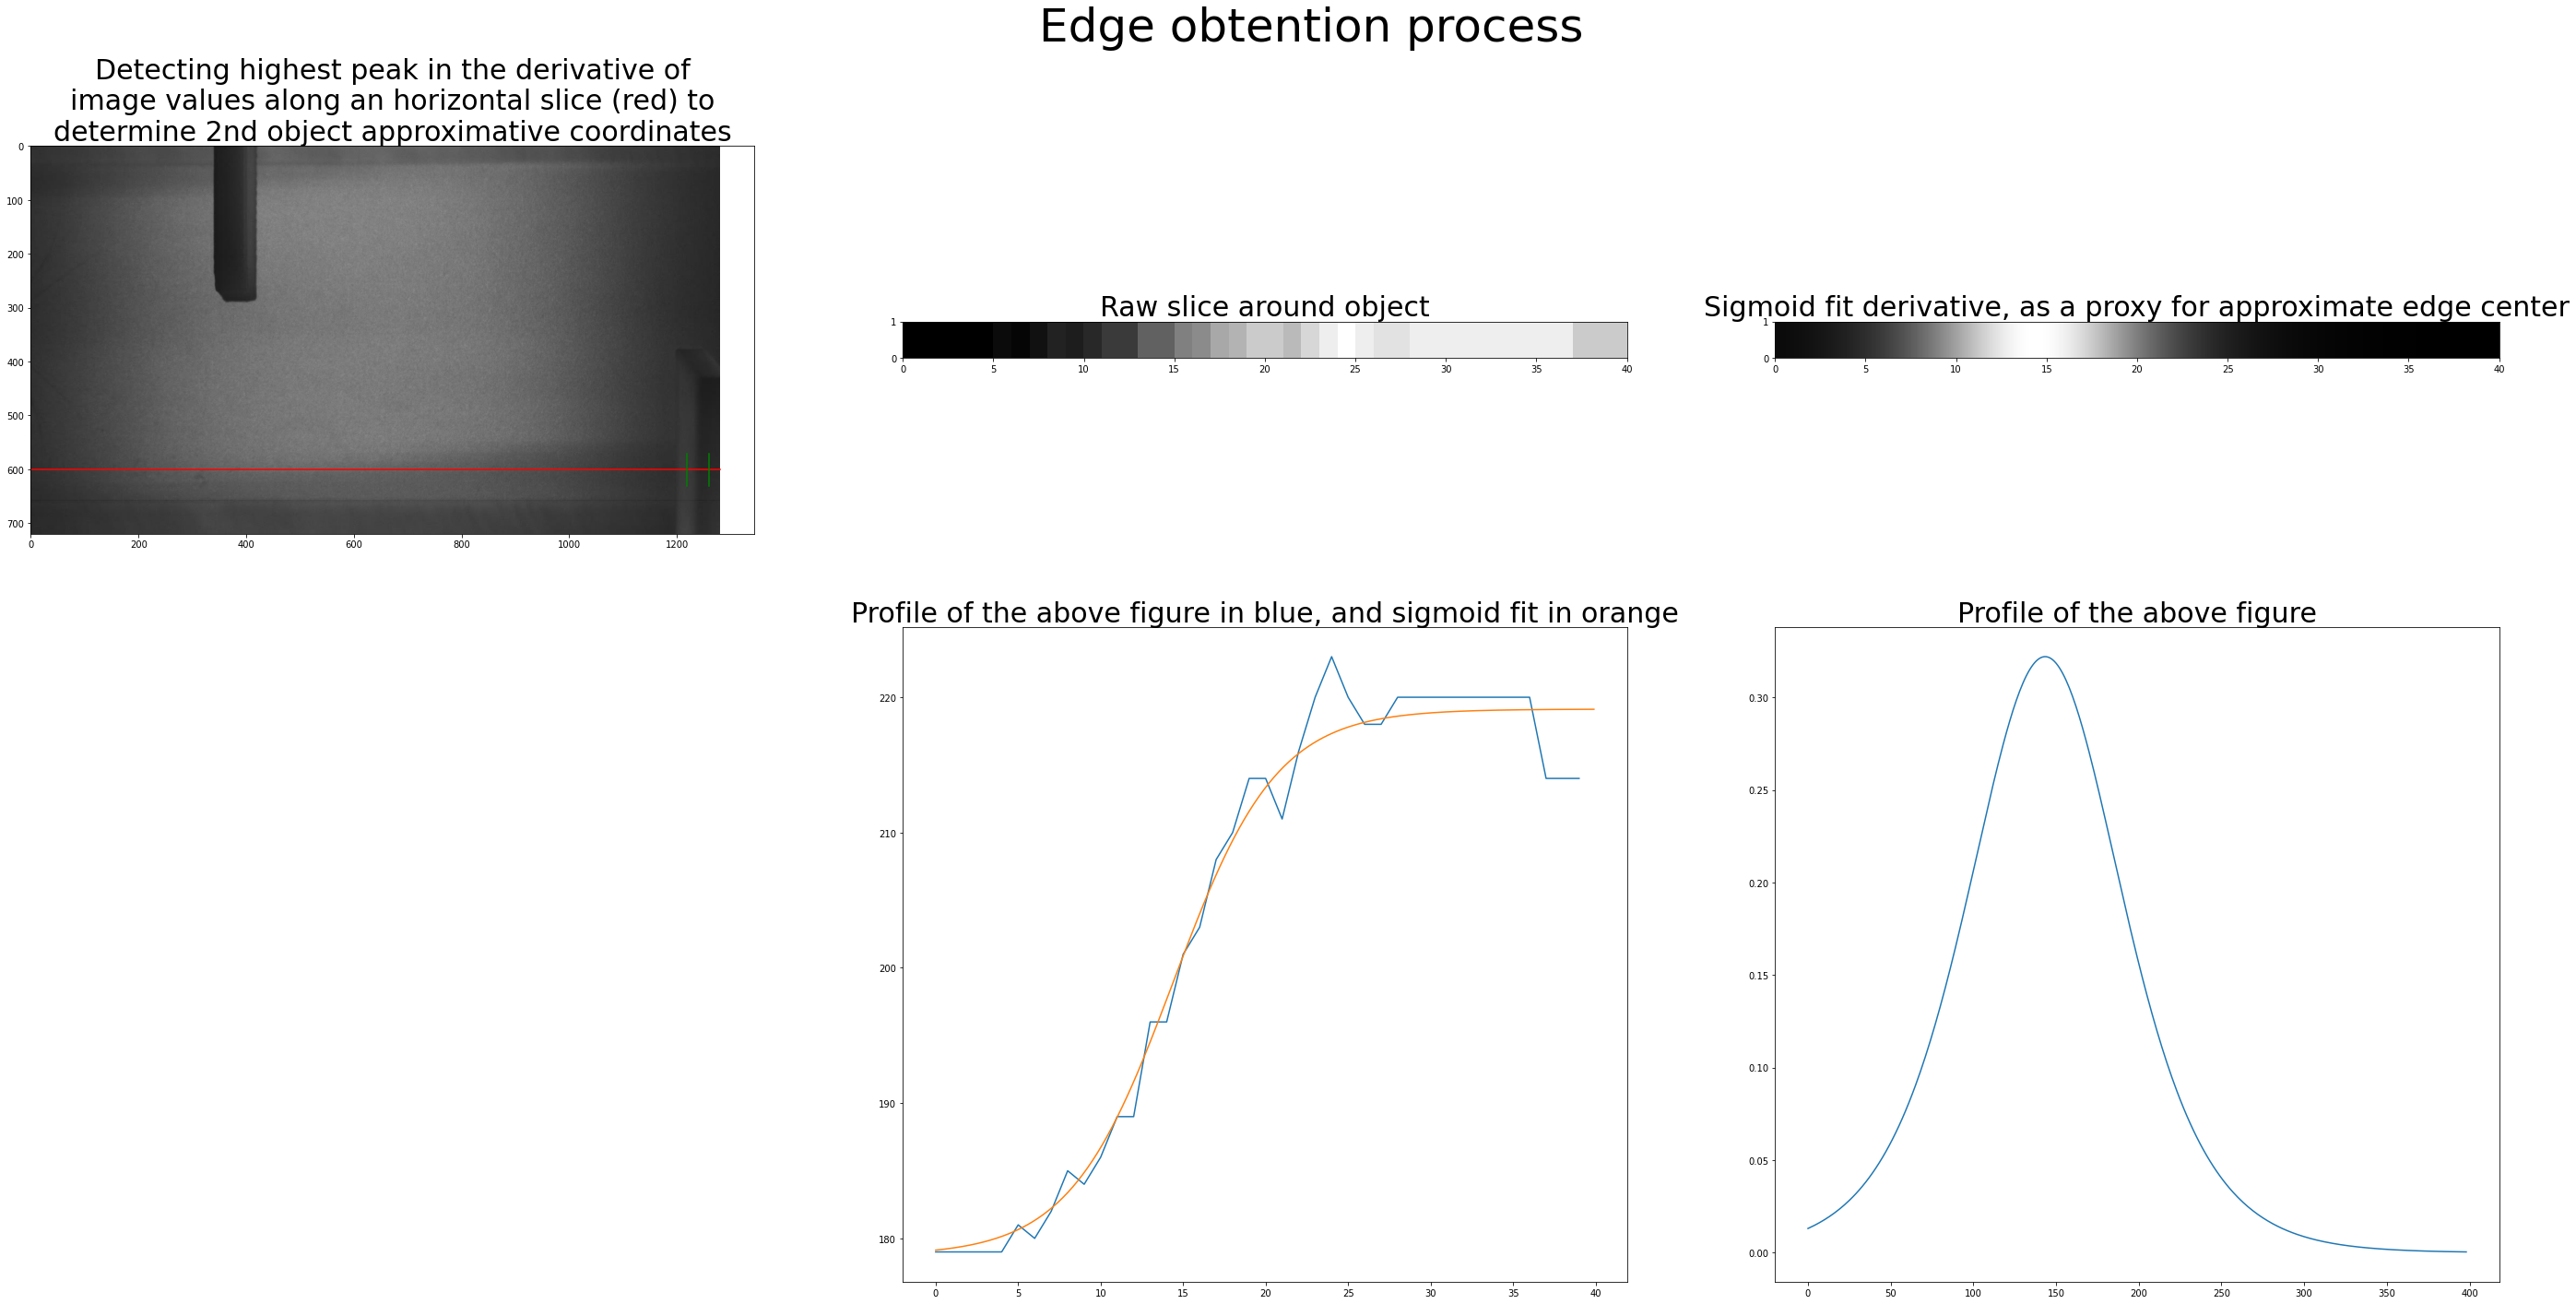

C:\ProgramData\Anaconda3\envs\ArduinoComs\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [56]:
TimeImage = np.empty((0,SliceLength))
Diff_TimeImage = np.empty((0,(SliceLength*interpMultiplicator)-1))

HandleBEHAV.set(cv2.CAP_PROP_POS_FRAMES,0)

for framne_nb in range(Videolength) :

    _ , Image = HandleBEHAV.read()

    Slice_temp = getHIT_LINE(Image,Obj_heights[Object],Reference_peaks2[0:2],reverse = True, clahe = True, axis = 1)

    TimeImage = np.append(TimeImage, Slice_temp ,axis = 0 )
    
    DiffSlice_temp, Fit = getSigmoidEdgePeak(Slice_temp, lowpass_raw = [b, a], lowpass_diff = [b2, a2], interp = interpMultiplicator )

    Diff_TimeImage = np.append(Diff_TimeImage, DiffSlice_temp ,axis = 0)
    
    if framne_nb == 1:
        fig = plt.figure(figsize = (40,20))

        PeakColor = 'red'

        plt.subplot(231)######################
        plt.imshow(Image, 'gray')
        plt.plot([0,np.shape(Image)[1]],[Obj_heights[Object],Obj_heights[Object]],PeakColor)
        plt.plot([Reference_peaks2[0],Reference_peaks2[0]],[Obj_heights[Object]+30,Obj_heights[Object]-30],'green')
        plt.plot([Reference_peaks2[1],Reference_peaks2[1]],[Obj_heights[Object]+30,Obj_heights[Object]-30],'green')
        plt.title("Detecting highest peak in the derivative of\nimage values along an horizontal slice (red) to\ndetermine 2nd object approximative coordinates",fontsize = 30)
        
        plt.subplot(232)######################
        plt.imshow(Slice_temp, 'gray', extent=[0,SliceLength,0,1], aspect=2)
        plt.title("Raw slice around object",fontsize = 30)
        
        ax = plt.subplot(233)######################
        plt.imshow(DiffSlice_temp, 'gray', extent=[0,SliceLength,0,1], aspect=2)
        plt.title("Sigmoid fit derivative, as a proxy for approximate edge center",fontsize = 30)
        
        ax = plt.subplot(235)######################
        plt.plot(Slice_temp.flatten())
        plt.plot(np.arange(0,np.shape(Slice_temp)[1],1/interpMultiplicator),Fit.flatten())
        plt.title("Profile of the above figure in blue, and sigmoid fit in orange",fontsize = 30)
        
        ax = plt.subplot(236)######################
        plt.plot(DiffSlice_temp.flatten())
        plt.title("Profile of the above figure",fontsize = 30)
        
        plt.tight_layout()
        fig.suptitle('Edge obtention process', fontsize=50)
        
        plt.savefig("fig3.png")
        plt.show()

## Extracting coordinates of edge sigmoids

In [57]:
edges = []
for I in range(np.shape(Diff_TimeImage)[0]):

    DPeaks , values = sig.find_peaks(Diff_TimeImage[I,:], height = 1/interpMultiplicator)
    DPeaks,values = HighestPeakFrom(DPeaks,values)
    edges.append(DPeaks)

edges = np.asarray(edges).astype(float)
edges = edges/interpMultiplicator
mean = np.nanmean(edges)
print(f"Mean of the values for the edge detected over time :{mean}")

Mean of the values for the edge detected over time :14.976599999999998


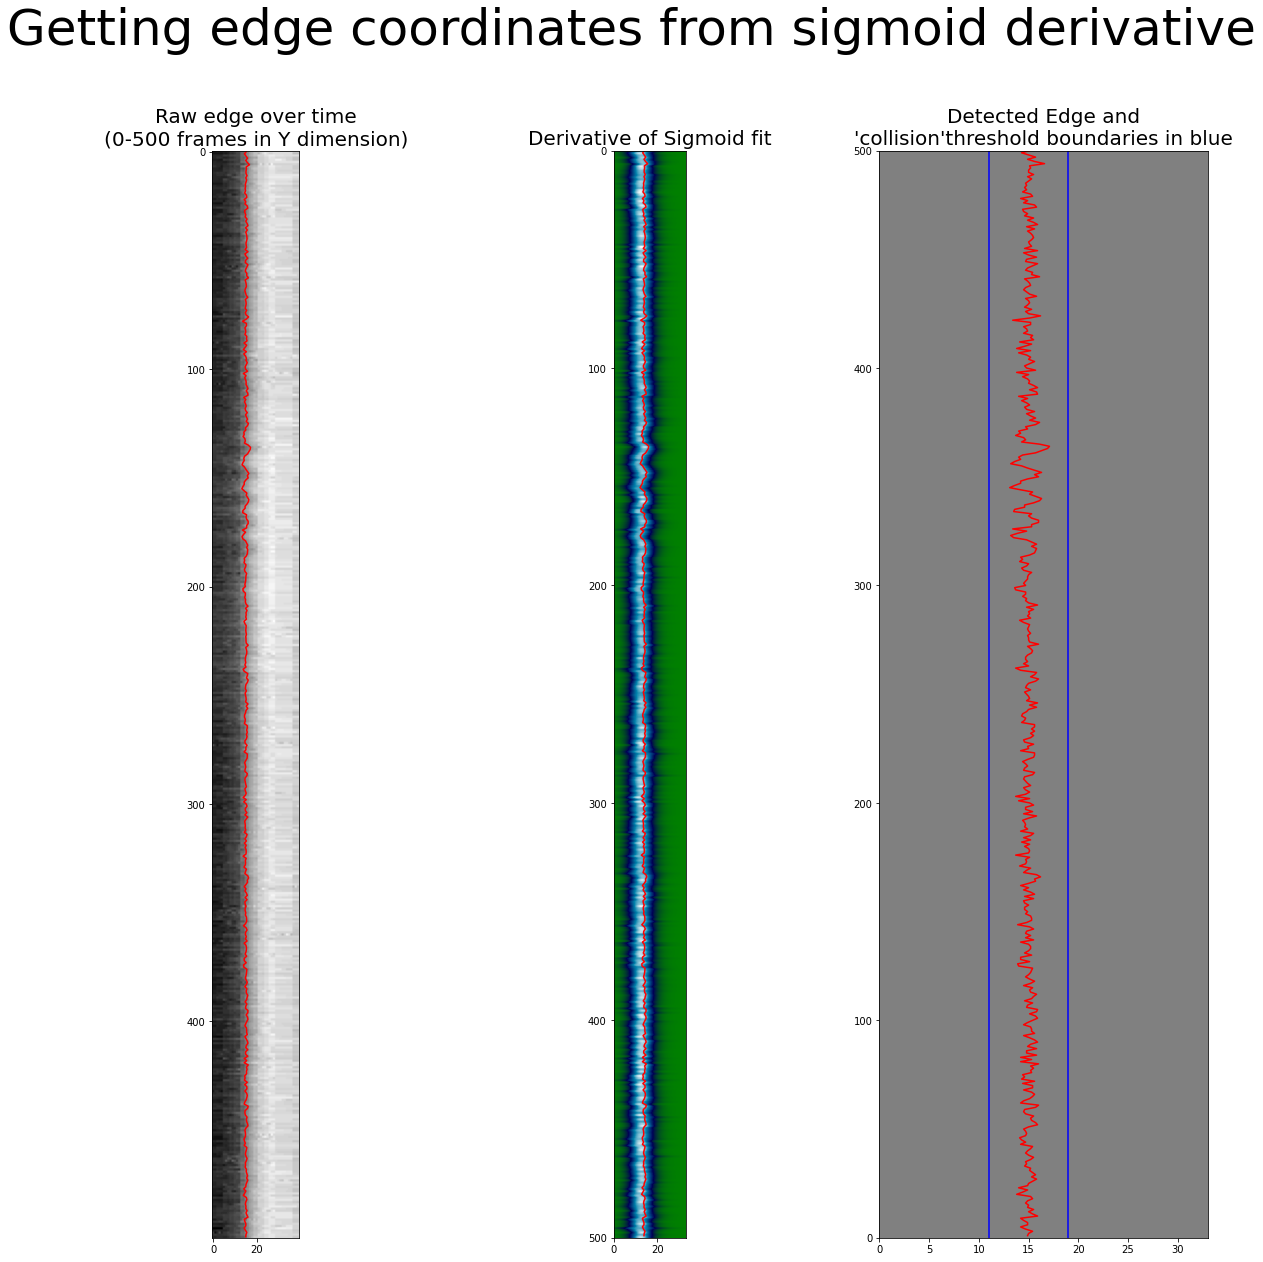

In [58]:
fig = plt.figure(figsize = (20,20))

PeakColor = 'red'

plt.subplot(131)######################
plt.imshow(TimeImage, 'gray')
plt.plot(edges,np.arange(0,len(edges),1),PeakColor)
plt.title("Raw edge over time\n(0-500 frames in Y dimension)",fontsize = 20)

plt.subplot(132)######################
plt.imshow(Diff_TimeImage, 'ocean', extent=[0,33,500,0], aspect=1)
plt.plot(edges-1,np.arange(0,len(edges),1),PeakColor)
plt.title("Derivative of Sigmoid fit",fontsize = 20)

ax = plt.subplot(133)######################
plt.plot(edges,np.arange(len(edges),0,-1),PeakColor)
plt.ylim(0,500)
plt.xlim(0,33)
plt.plot([mean-4,mean-4],[0,500],'blue')
plt.plot([mean+4,mean+4],[0,500],'blue')
ax.set_facecolor('gray')
plt.title("Detected Edge and\n'collision'threshold boundaries in blue",fontsize = 20)

fig.suptitle('Getting edge coordinates from sigmoid derivative', fontsize=50)

plt.savefig("fig4.png")
plt.show()

## Saving edges of object 2 in a copied array

In [59]:
edges_Obj2 = np.copy(edges)

C:\ProgramData\Anaconda3\envs\ArduinoComs\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


(500,)
['NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 4.083093033766163, 5.006515896158408, 5.0765833395893605, 4.3502510532665735, 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN

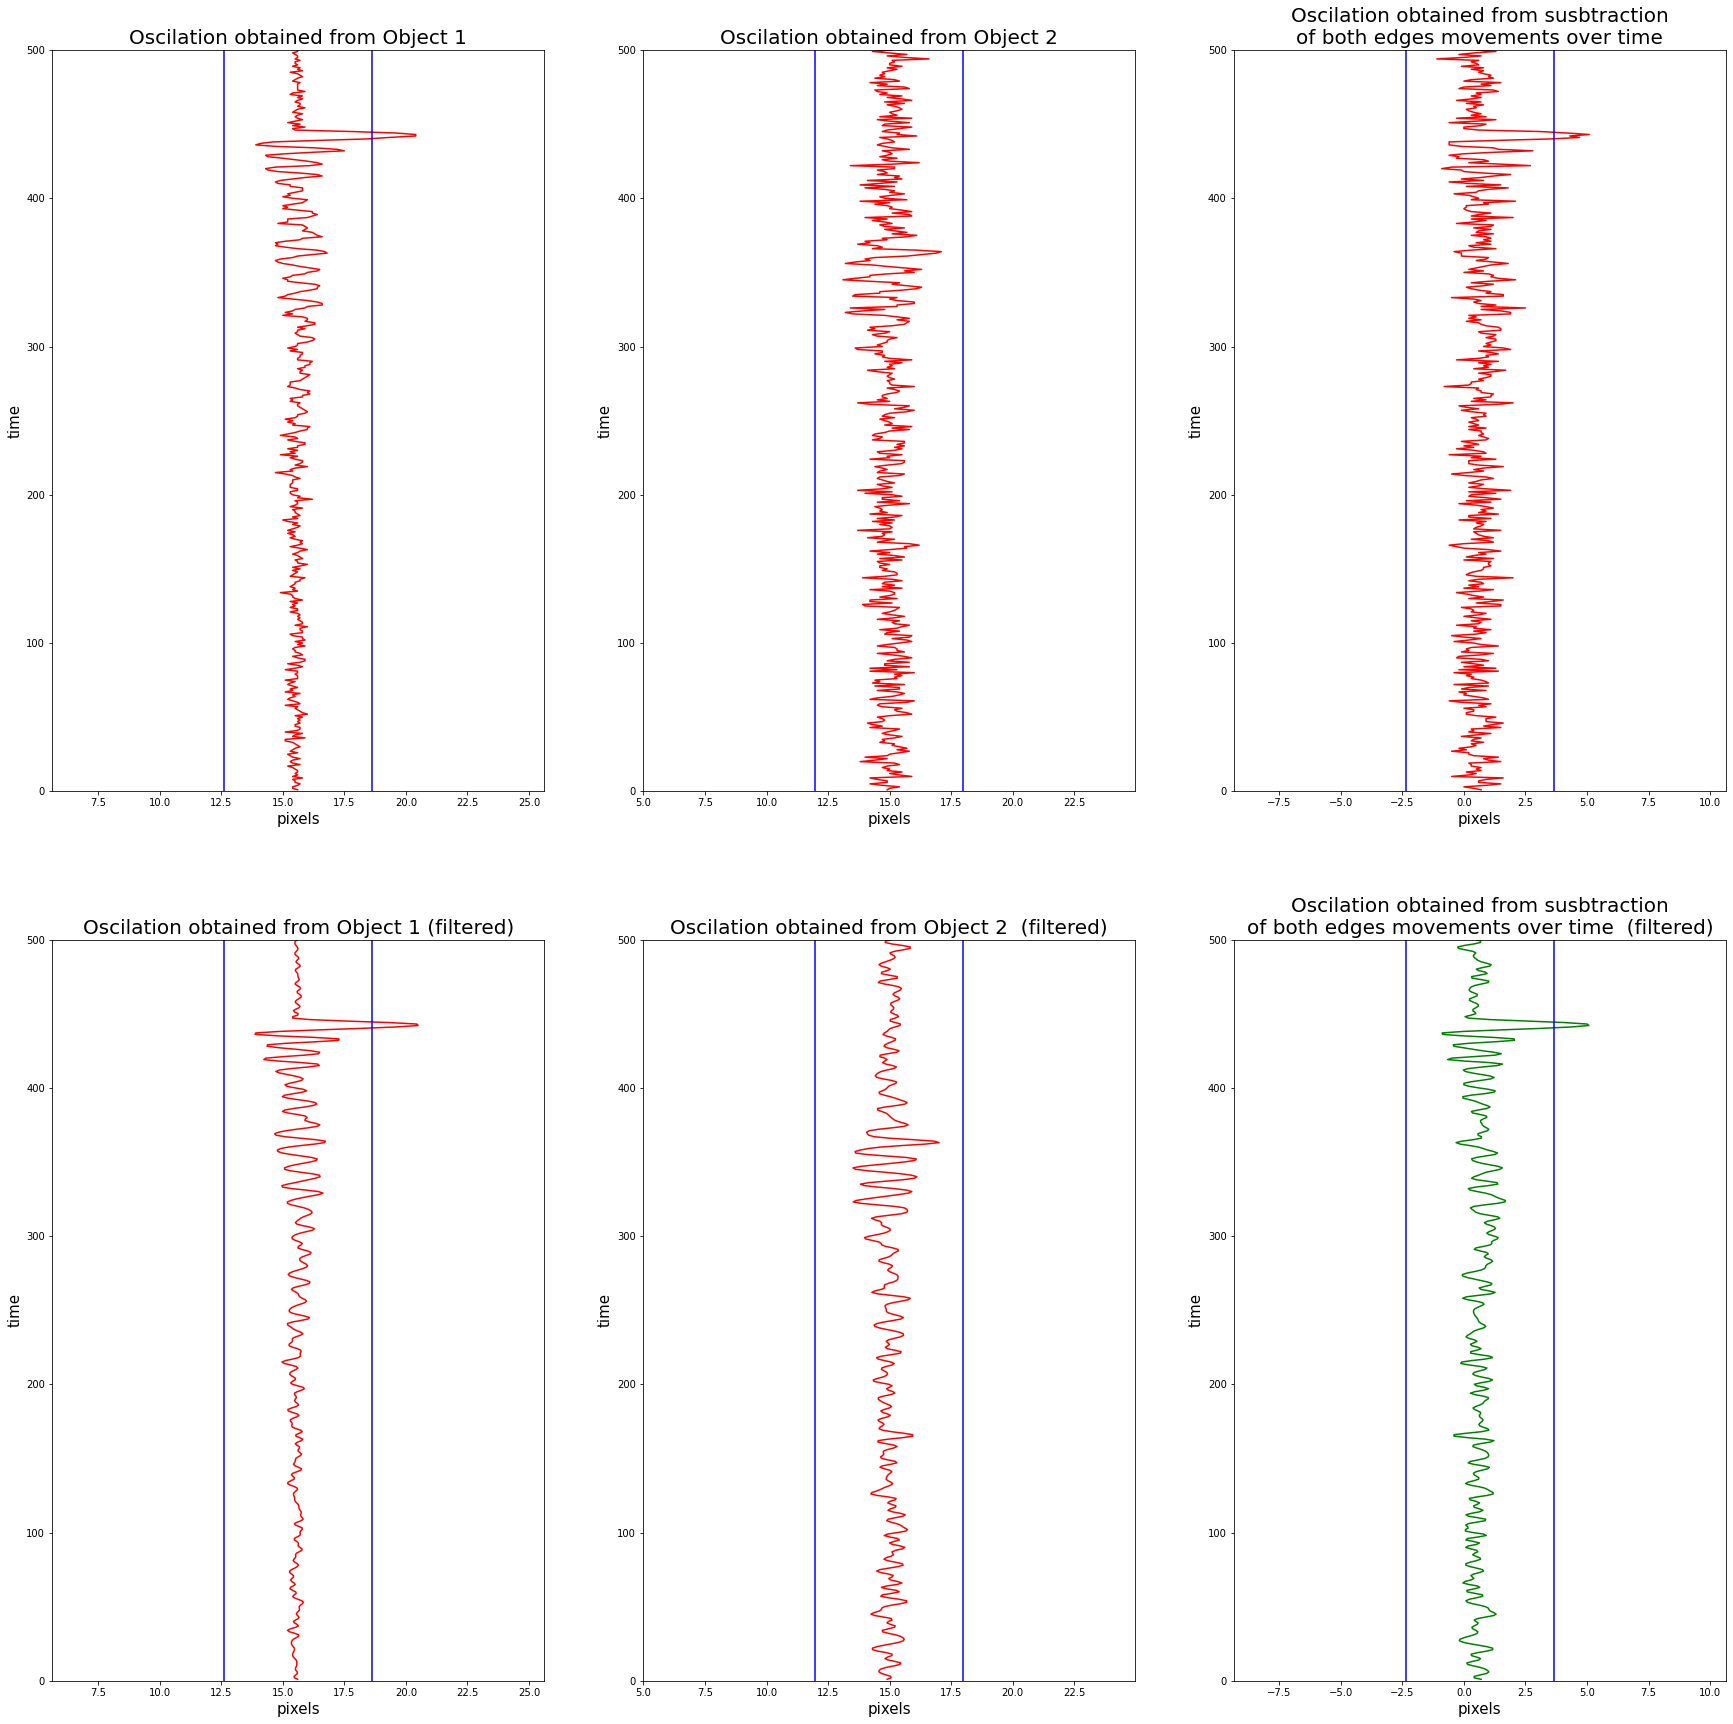

In [60]:
obj1mean = np.nanmean(edges_Obj1)
obj2mean = np.nanmean(edges_Obj2)

b3, a3 = butter(7, 0.400)
filtobj1 = filtfilt(b3, a3, edges_Obj1)  
filtobj2 = filtfilt(b3, a3, edges_Obj2)  


MetaEDGE = edges_Obj1 - edges_Obj2
MetaMean = np.nanmean(MetaEDGE)

MetaEDGE_filt = filtobj1 - filtobj2


print(np.shape(MetaEDGE_filt))



MetaEDGE_filtList = []

for i in MetaEDGE_filt:
      
    if i <= (MetaMean-3) or i >= (MetaMean+3):    

        MetaEDGE_filtList.append(i)

    else : 
        MetaEDGE_filtList.append('NaN')
        
print(MetaEDGE_filtList)


fig = plt.figure(figsize = (30,30))

plt.subplot(231)######################
plt.plot(edges_Obj1,np.arange(len(edges_Obj1),0,-1),PeakColor)
plt.ylabel("time",fontsize = 15)
plt.xlabel("pixels",fontsize = 15)
plt.ylim(0,500)
plt.xlim(obj1mean-10,obj1mean+10)
plt.plot([obj1mean-3,obj1mean-3],[0,500],'blue')
plt.plot([obj1mean+3,obj1mean+3],[0,500],'blue')
plt.title("Oscilation obtained from Object 1",fontsize = 20)

plt.subplot(232)######################
plt.plot(edges_Obj2,np.arange(len(edges_Obj2),0,-1),PeakColor)
plt.ylabel("time",fontsize = 15)
plt.xlabel("pixels",fontsize = 15)
plt.ylim(0,500)
plt.xlim(obj2mean-10,obj2mean+10)
plt.plot([obj2mean-3,obj2mean-3],[0,500],'blue')
plt.plot([obj2mean+3,obj2mean+3],[0,500],'blue')
plt.title("Oscilation obtained from Object 2",fontsize = 20)

plt.subplot(233)######################
plt.plot(MetaEDGE,np.arange(len(MetaEDGE),0,-1),PeakColor)
plt.ylabel("time",fontsize = 15)
plt.xlabel("pixels",fontsize = 15)
plt.ylim(0,500)
plt.xlim(MetaMean-10,MetaMean+10)
plt.plot([MetaMean-3,MetaMean-3],[0,500],'blue')
plt.plot([MetaMean+3,MetaMean+3],[0,500],'blue')
plt.title("Oscilation obtained from susbtraction\nof both edges movements over time",fontsize = 20)

plt.subplot(234)######################
plt.plot(filtobj1,np.arange(len(edges_Obj1),0,-1),PeakColor)
plt.ylabel("time",fontsize = 15)
plt.xlabel("pixels",fontsize = 15)
plt.ylim(0,500)
plt.xlim(obj1mean-10,obj1mean+10)
plt.plot([obj1mean-3,obj1mean-3],[0,500],'blue')
plt.plot([obj1mean+3,obj1mean+3],[0,500],'blue')
plt.title("Oscilation obtained from Object 1 (filtered)",fontsize = 20)

plt.subplot(235)######################
plt.plot(filtobj2,np.arange(len(edges_Obj2),0,-1),PeakColor)
plt.ylabel("time",fontsize = 15)
plt.xlabel("pixels",fontsize = 15)
plt.ylim(0,500)
plt.xlim(obj2mean-10,obj2mean+10)
plt.plot([obj2mean-3,obj2mean-3],[0,500],'blue')
plt.plot([obj2mean+3,obj2mean+3],[0,500],'blue')
plt.title("Oscilation obtained from Object 2  (filtered)",fontsize = 20)

plt.subplot(236)######################
plt.plot(MetaEDGE_filt,np.arange(len(MetaEDGE),0,-1),'green')
plt.ylabel("time",fontsize = 15)
plt.xlabel("pixels",fontsize = 15)
plt.ylim(0,500)
plt.xlim(MetaMean-10,MetaMean+10)
plt.plot([MetaMean-3,MetaMean-3],[0,500],'blue')
plt.plot([MetaMean+3,MetaMean+3],[0,500],'blue')
plt.title("Oscilation obtained from susbtraction\nof both edges movements over time  (filtered)",fontsize = 20)

plt.savefig("fig5.png")
plt.show()

## Shifting of the object at the end of the video is removed from signal ! EUREKA !


Now there is the need to make a function in the style of findreferencesystem, that takes a video path as an input, and outputs the metaEdge coordinates (plotted in green above)
Idealy, the function would take some optional arguments like ****kwargs** as inputs, to be able to tweak parameters like object heights, clahe, filters etc. 
Of course, this can be done in a second time, after a simple function with only one argument works fine !